# Time Series to observe DAILY temperature variations 
## Daily temperature prediction using ARIMA


## Autoregressive Integrated Moving Average Model
An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

**p**: The number of lag observations included in the model, also called the lag order. <br>
**d**: The number of times that the raw observations are differenced, also called the degree of differencing.<br>
**q**: The size of the moving average window, also called the order of moving average.<br>

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.


In [38]:
import warnings
warnings.filterwarnings('ignore')

%run helper_functions.py
%matplotlib inline

Install custom lib for hyper-parameter searching for ARIMA

In [376]:
# !pip install pyramid-arima

Create a folder for every run of the RNN to store images

In [6]:
EXPERIMENT_DIR = create_results_perrun()
print("Path of the results directory",EXPERIMENT_DIR )

Path of the results Image directory ../Images/RESULTS/RUN-17


In [204]:
city='Los_Angeles'
Y_train = pd.read_pickle(f'{PICKLE_PATH}/Y_train_{city}.pkl')
Y_test  = pd.read_pickle(f'{PICKLE_PATH}/Y_test_{city}.pkl')

print("Shape of Training Dataset " , Y_train.shape)
print("Shape of Testing Dataset " , Y_test.shape)

freq=365

Shape of Training Dataset  (1432, 1)
Shape of Testing Dataset  (90, 1)


Lets also do a decomposition, to identify the trend, seasonal and residuals of the timeseries. 

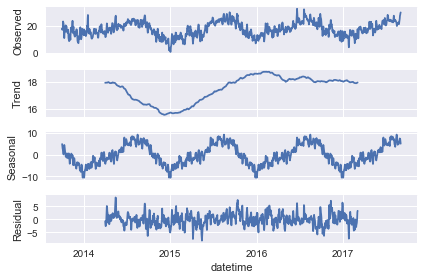

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose
dsd = seasonal_decompose(Y_train, model='additive',freq=365)
dsd.plot()
plt.show()

We can see a seasonal component and a horizontal trend that is linear +/- 1

### Differencing the series

If a graphical plot of the data indicates nonstationarity, then you should "difference" the series. So, lets plot an autocorrelation and partial autocorrelation plot to examine the series.

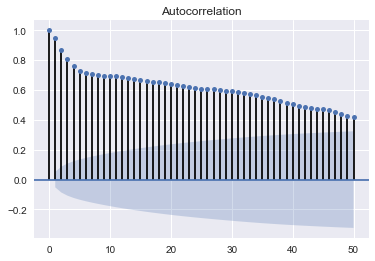

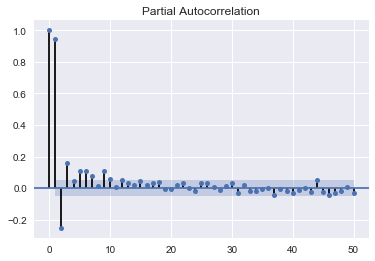

In [131]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(Y_train, lags=50)
plot_pacf(Y_train, lags=50)
plt.show()

In this example, we can see an decaying pattern, indicating we need to difference the series.

Differencing is an excellent way of transforming a nonstationary series to a stationary one. This is done by subtracting the observation in the current period from the previous one. If this transformation is done only once to a series, you say that the data has been "first differenced". This process essentially eliminates the trend if your series is growing at a fairly constant rate. If it is growing at an increasing rate, you can apply the same procedure and difference the data again. Your data would then be "second differenced".

In [134]:
#/first difference
diff_test_set = Y_train.diff().fillna(method='bfill')
diff_test_set.head(5)

,temperature
datetime,
2013-10-01,-0.798487
2013-10-02,-0.798487
2013-10-03,1.473410
2013-10-04,0.844677
2013-10-05,3.810417


Running the autocorrelation plot again, shows the differencing has removed the cyclic pattern and the time series is however still not stationary.

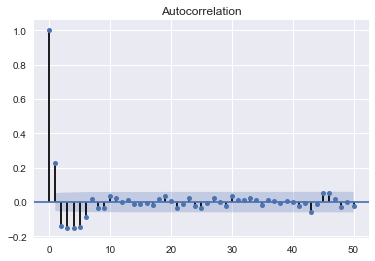

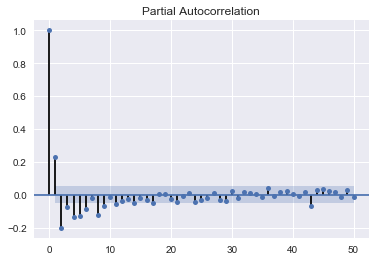

In [135]:
plot_acf(diff_test_set, lags=50)
plot_pacf(diff_test_set, lags=50)
plt.show()

Next lets run an augmented dickey fuller test, to see if we have stationarity

In [147]:
from statsmodels.tsa.stattools import adfuller
adf_df = adfuller(diff_test_set['temperature'], autolag='AIC')

for key,value in adf_df[4].items():
    print(f'Critical Value ({key})) - {value}')

Critical Value (1%)) - -3.434979825137732
Critical Value (5%)) - -2.8635847436211317
Critical Value (10%)) - -2.5678586114197954


The values indicate the series is still not stationary and it requires a more complex model using an autoregressive or moving average ( or both ).

We have learned how to to decompose and test a time series for stationarity, now lets use an auto arima function that will perform hyper-parameter tuning.

In [246]:
from pyramid.arima import auto_arima
model_fit = auto_arima(Y_train, start_p=1, start_q=1, max_p=2, max_q=2, m=12, max_P=1, max_Q=1,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                            n_fits=20)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5414.099, BIC=5445.700, Fit time=6.419 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=5302.123, BIC=5338.991, Fit time=11.679 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5412.152, BIC=5438.486, Fit time=5.501 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=5300.370, BIC=5331.971, Fit time=6.308 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 29.922 seconds


Lets review the model and the summary of the auto fit routine

In [247]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1432
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2644.185
Date:                            Tue, 14 Aug 2018   AIC                           5300.370
Time:                                    13:34:20   BIC                           5331.971
Sample:                                         0   HQIC                          5312.170
                                           - 1432                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.273e-05      0.000      0.592      0.554      -0.000       0.000
ar.L1          1.0710      0.027     40.020      0.000       1.019       1.123
ar.L2         -0.3537      0.023    -15.532      0.000      -0.398      -0.309
ma.L1         -0.8949      0.019    -46.174      0.000      -0.933      -0.857
ma.S.L12      -0.9939      0.028    -36.041      0.000      -1.048      -0.940
sigma2         2.3466      0.082     28.448      0.000       2.185       2.508
===================================================================================
Ljung-Box (Q):                       45.84   Jarque-Bera (JB):               179.78
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Lets create an in-sample prediction ( using the data we fit with model with )

In [269]:
in_sample_preds = model_fit.predict_in_sample()

array([ 0.        , 17.83861878, 17.0402024 , ..., 27.14699541,
       27.23811781, 28.52676073])

Then lets review the MSE of this

In [284]:
mse_train = mean_squared_error(Y_train, in_sample_preds)
print('Mean Squared Error for the testing dataset: %.3f' % mse_train)    

Mean Squared Error for the testing dataset: 2.821


Now let us plot this in-sample-prediction so we can see how our model fits to our datasetv

In [327]:
predictions_df = pd.DataFrame(in_sample_preds, index=Y_train.index, columns=['Fitted'])
predictions_df

combined_df = Y_train.join(predictions_df, how="left")

fig = charter_helper_fitted("Daily In-Sample Predicted Temperature using ARIMA for " + city, combined_df)
iplot(fig)

py.image.save_as(fig, filename=f'{EXPERIMENT_DIR}/Daily_ARIMA_actual_vs_predict.png')

This in-sample prediction looks impressive and the MSE indicates a good fit vs the underlying dataset. 
Now, lets forecast into the future ( based on the Y_test dataset )

In [321]:
model_forecast = model_fit.predict(n_periods=len(Y_test))

forecast_df = pd.DataFrame(model_forecast, index=Y_test.index, columns=['Fitted'])
combined_forecast_df = Y_test.join(forecast_df, how="left")


In [322]:
mse_test = mean_squared_error(Y_test, forecast_df)
print('Mean Squared Error for the testing dataset: %.3f' % mse_test) 

Mean Squared Error for the testing dataset: 51.305


In [328]:
# Plotting the training data for past year, Actual/test data and predicted temperature - Decision Tree
fig = charter_helper_prediction("Daily Forecast Temperature using ARIMA for " + city, Y_train, Y_train, combined_forecast_df,combined_forecast_df,combined_forecast_df)

iplot(fig)
py.image.save_as(fig, filename=f'{EXPERIMENT_DIR}/Daily_ARIMA_predict.png')

## Conclusion
The ARIMA model forecast isnt particularly impressive (after all this work), the forecast initially trends correctly but then the forecasts of the future values rapidly damped out and subsequently have no predictive power. We would either have to introduce the forecasted values onto the end of the timeseries and have the model update its training or introduce a more powerful form of model such as SARIMAX (which is a state space model).